### IMPORT LIBRARIES

In [4]:
pip install -U scikit-image

Note: you may need to restart the kernel to use updated packages.


In [5]:
from skimage import io
from skimage.color import rgb2gray

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import io
from skimage.color import rgb2gray

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### IMPORT / VIEWING / PREPROCESSING DATASET

> `DATA AUGMENTATION`

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [11]:
train_dataset  = train_datagen.flow_from_directory(directory = 'C:/Users/Dell/Alzheimers-ADNI/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 883 images belonging to 5 classes.


In [12]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'C:/Users/Dell/Alzheimers-ADNI/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 218 images belonging to 5 classes.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.07s/it]


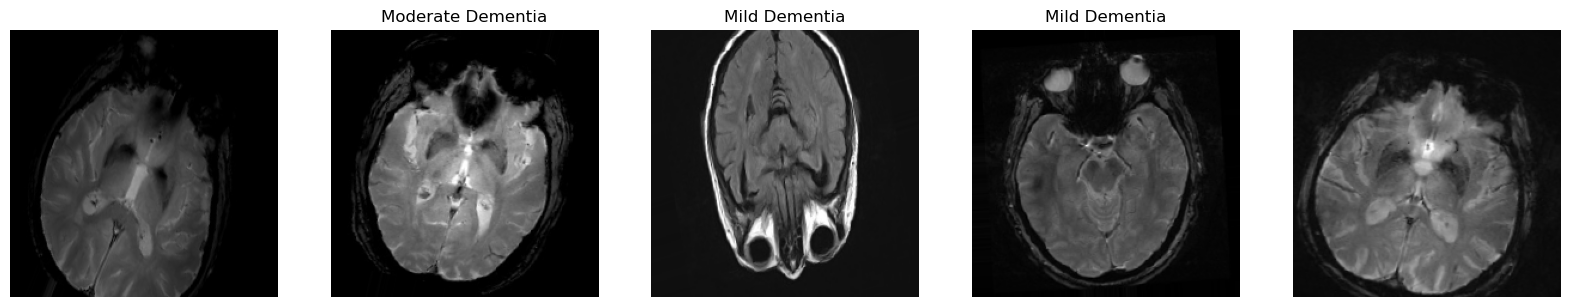

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

### MODEL BUILDING

In [6]:
# Model Initialization

base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

51879936/51877672 [==============================] - 1s 0us/step


In [8]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [9]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [10]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1664)        0         
_________________________________________________________________
flatten (Flatten)            (None, 81536)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 81536)             326144    
_________________________________________________________________
dense (Dense)                (None, 2048)              166987776 
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [11]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [12]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [13]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 500,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/500
33/33 [==============================] - ETA: 0s - loss: 1.3226 - auc: 0.7894
Epoch 00001: val_auc improved from -inf to 0.68573, saving model to ./best_weights.hdf5
33/33 [==============================] - 72s 2s/step - loss: 1.3226 - auc: 0.7894 - val_loss: 5.2772 - val_auc: 0.6857
Epoch 2/500
33/33 [==============================] - ETA: 0s - loss: 1.0816 - auc: 0.8324
Epoch 00002: val_auc improved from 0.68573 to 0.73006, saving model to ./best_weights.hdf5
33/33 [==============================] - 76s 2s/step - loss: 1.0816 - auc: 0.8324 - val_loss: 2.5155 - val_auc: 0.7301
Epoch 3/500
33/33 [==============================] - ETA: 0s - loss: 0.9912 - auc: 0.8498
Epoch 00003: val_auc did not improve from 0.73006
33/33 [==============================] - 54s 2s/step - loss: 0.9912 - auc: 0.8498 - val_loss: 2.3908 - val_auc: 0.7253
Epoch 4/500
33/33 [==============================] - ETA: 0s - loss: 0.9562 - auc: 0.8560
Epoch 00004: val_auc improved from 0.73006 to 0.75874,

### MODEL EVALUATION

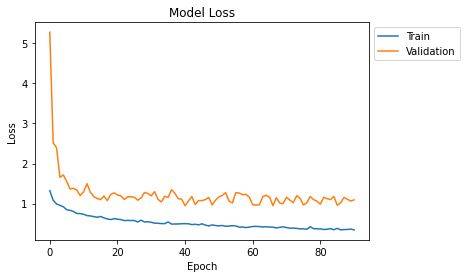

In [14]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

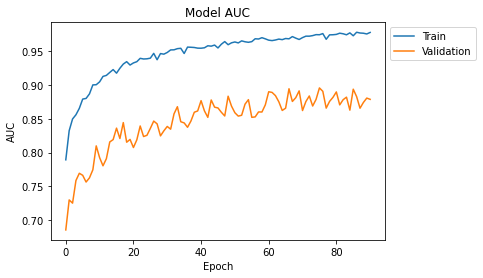

In [15]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [17]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 1279 images belonging to 4 classes.


In [18]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

10/10 [==============================] - 4s 448ms/step - loss: 1.2377 - auc: 0.8870


[1.2377309799194336, 0.8869889378547668]

99.93 % chances are there that the image is NonDemented


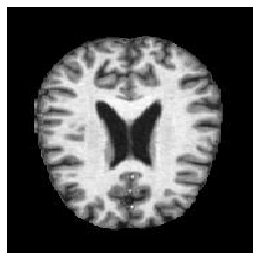

In [42]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

97.86 % chances are there that the image is MildDemented


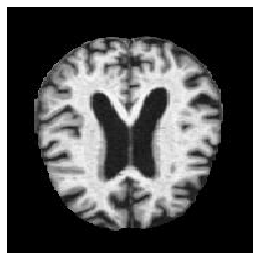

In [43]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

86.79 % chances are there that the image is ModerateDemented


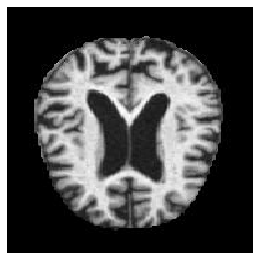

In [44]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

91.97 % chances are there that the image is VeryMildDemented


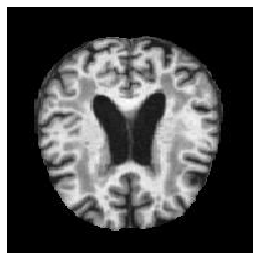

In [45]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

Conclusion:

So, we have finally built are deep learning model using DenseNet162 transfer learning algorithm and acheived and AUC-90%.